In [1]:
import matplotlib
matplotlib.use('nbagg')
print(matplotlib.get_backend())


nbAgg


In [2]:
import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv

loading data from directory

In [3]:
dataset_location = 'C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/images'
#dataset_location = 'C:/Users/sushl/Downloads/Archives/data_odometry_gray/dataset/sequences/07/image_0'
L = os.listdir(dataset_location)
L.sort()
#print(L)

ground_truth

In [4]:
ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/poses.txt',delimiter = ' ')
#ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Archives/data_odometry_poses/dataset/poses/05.txt',delimiter = ' ')
#ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Archives/data_odometry_poses/dataset/poses/07.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:150,3]
gz = ground_truth[:150,11]

calibration matrix

In [5]:

k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
             [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])

"""
k = np.array([[518.56666108, 0., 329.45801792],
    [0., 518.80466479, 237.05589955],
    [  0., 0., 1.]])
"""

'\nk = np.array([[518.56666108, 0., 329.45801792],\n    [0., 518.80466479, 237.05589955],\n    [  0., 0., 1.]])\n'

In [6]:
sift = cv.SIFT_create()
bf = cv.BFMatcher()

function for triangulating Points

In [7]:
def point3D(k,R,t,pts1,pts2):
    rt = np.zeros((3,4))
    rt[:3,:3] = np.identity(3)
    projMatr1 = k@rt
    rt2 = np.zeros((3,4))
    rt2[:3,:3] = R
    rt2[:,3] = t.reshape((3))
    projMatr2 = k@rt2
    points4D = cv.triangulatePoints(projMatr1,projMatr2,pts1 ,pts2)
    points3D = points4D / points4D[3,:]
    return points3D.T

function for calculating scale

by finding distance ratio

In [8]:
def RelativeScale1(last_cloud, new_cloud):
    min_idx = min([new_cloud.shape[0],last_cloud.shape[0]])
    p_Xk = new_cloud[:min_idx]
    Xk = np.roll(p_Xk,shift = -10)
    p_Xk_1 = last_cloud[:min_idx]
    Xk_1 = np.roll(p_Xk_1,shift = -10)
    d_ratio = (np.linalg.norm(p_Xk_1 - Xk_1,axis = -1))/(np.linalg.norm(p_Xk - Xk,axis = -1))

    return np.median(d_ratio)

by projecting old 3d cloud on to the new one

In [9]:
def RelativeScale2(last_cloud, new_cloud,R,t):
    min_idx = min([new_cloud.shape[0],last_cloud.shape[0]])
    p_Xk = new_cloud[:min_idx,:3]
    p_Xk_1 = last_cloud[:min_idx,:3]
    s = np.linalg.inv(p_Xk_1@p_Xk_1.T)@p_Xk_1@R.T@(p_Xk.T - t)
    return abs(np.median(s))

calculating trajectory by calculating scale

In [10]:

scale = 1
trans= {}
rot = {}

for a in range(len(L)-2):
    #start2 = timeit.timeit()
    sift = cv.SIFT_create()
    bf = cv.BFMatcher()

    img1 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(dataset_location +'/'+ L[a+1],cv.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    matches = bf.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    src_p = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_p=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    pts1 = np.float32(src_p)
    pts2 = np.float32(dst_p)

    R = []
    t = []
    
    #F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    F,mask = cv.findFundamentalMat(pts1, pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
    E = k.T@F@k
        
    retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
    
    if a == 0:
        trans[a] = -1*R@t
        rot[a] = R
    else:
        rot[a] = rot[a-1]@R
        trans[a] = trans[a-1] - rot[a]@t



In [11]:
translations1 = []
translations1.append(np.zeros((3,1)))
rotations1 = []
rotations1.append(np.identity(3))
scale1 = []
pointcloud = []
error_set = []

for a in range(len(L)-2):
    old_cloud = pointcloud
    img1 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(dataset_location +'/'+ L[a+1],cv.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    matches = bf.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    src_p = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_p=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    pts1 = np.float32(src_p)
    pts2 = np.float32(dst_p)

    R = []
    t = []
    #F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    F,mask = cv.findFundamentalMat(pts1, pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
    E = k.T@F@k
    #E, mask = cv.findEssentialMat(pts1,pts2,k,cv.RANSAC, prob = 0.999,threshold = 0.4,mask=None)
    #print(pts1)
    retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
    if a == 0:
        #pc = point3D(k,R,t,pts1,pts2)
        #pc = pc[:,:3]
        #retval, rvec, t, inliers = cv.solvePnPRansac(pc,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.50,flags = 1)
        #R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R,t,pts1,pts2)
        translations1.append(t)
        #print(t)
        rotations1.append(R)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        #print(a,np.min(norm_err))
        
    elif a == len(L)-1:
        #pc = point3D(k,R,t,pts1,pts2)
        #pc = pc[:,:3]
        #retval, rvec, t, inliers = cv.solvePnPRansac(pc,pts2, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 200,reprojectionError = 8.0,confidence = 0.90,flags = 1)
        #R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R,t,pts1,pts2)
        #print(t)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t+ translations1[a])
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        #print(a,np.min(norm_err))
        
    else:
        #pc = point3D(k,R,t,pts1,pts2)
        #pc = pc[:,:3]
        #retval, rvec, t, inliers = cv.solvePnPRansac(pc,pts2, k, (0,0,0.001,0),useExtrinsicGuess = True ,iterationsCount = 400,reprojectionError = 1.0,confidence = 0.70,flags = 1)
        #R,Jec = cv.Rodrigues(rvec)
        pointcloud = point3D(k,R,t,pts1,pts2)
        #print(t)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations1[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        #print(a,np.min(norm_err))

<IPython.core.display.Javascript object>


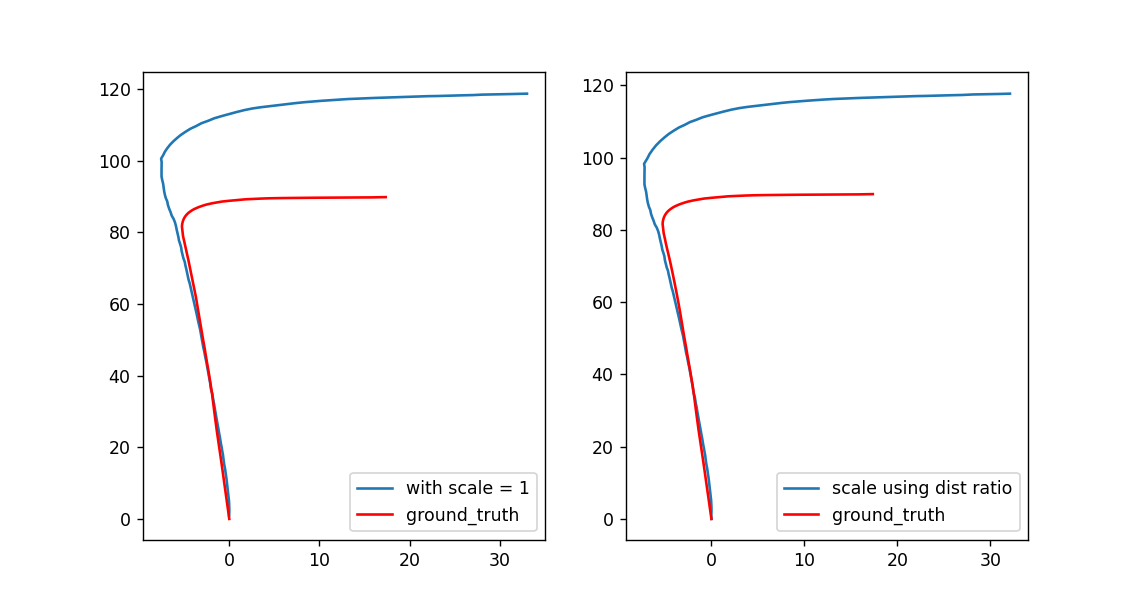

In [16]:

x0 = []
y0 = []

for i in trans:
    y0.append(trans[i][2])
    x0.append(-1*trans[i][0])

x1 = []
y1 = []

for i in range(len(translations1)-1):
    y1.append(translations1[i][2])
    x1.append(-1*translations1[i][0])

fig,axes = plt.subplots(ncols = 2)
axes[0].plot(x0,y0,label = 'with scale = 1')
axes[0].plot(gx, gz,color = 'red',label = 'ground_truth')
axes[1].plot(x1, y1,label = 'scale using dist ratio')
axes[1].plot(gx, gz,color = 'red',label = 'ground_truth')

axes[1].legend()
axes[0].legend()

plt.show()


<IPython.core.display.Javascript object>


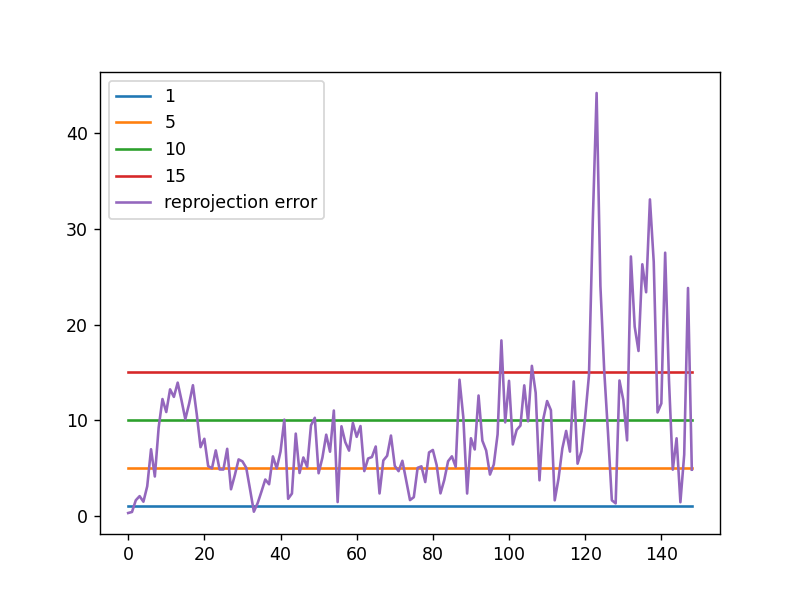

In [15]:
x0 = []
x1 = []
x2 = []
y0 = []
y1 = []
y2 = []
for i in range(len(error_set)-1):
    y0.append(error_set[i])
    x0.append(i)
    y1.append(1)
    y2.append(5)
    x1.append(10)
    x2.append(15)
    
fig,axes = plt.subplots()
axes.plot(x0, y1,label = '1')
axes.plot(x0, y2,label = '5')
axes.plot(x0, x1,label = '10')
axes.plot(x0, x2,label = '15')
axes.plot(x0, y0,label = 'reprojection error')
axes.legend()

plt.show()